In [1]:
import time

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

import jax.numpy as np
from jax import ops, random

import numpyro.distributions as dist
from numpyro.handlers import sample
from numpyro.hmc_util import initialize_model
from numpyro.mcmc import hmc
from numpyro.util import fori_collect

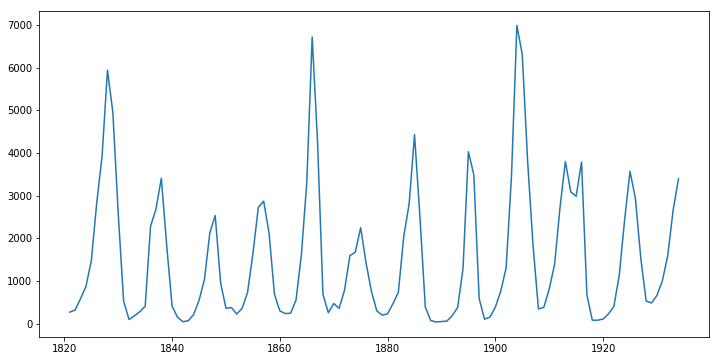

In [2]:
lynx = pd.read_csv("lynx.csv", index_col=0)
data = lynx["value"].values
plt.figure(figsize=(12, 6))
plt.plot(lynx["time"], data);

In [3]:
# Source: https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R
# model params
CAUCHY_SD_DIV = 150
MIN_NU = 2
MAX_NU = 20
MIN_POW_TREND = -0.5
MAX_POW_TREND = 1
POW_TREND_ALPHA = 1
POW_TREND_BETA = 1
MIN_SIGMA = 1e-10

# mcmc params
ADAPT_DELTA = 0.9
MAX_TREE_DEPTH = 12
NUM_OF_ITER = 2000

# data params
ADD_JITTER = True
MIN_VAL = 1e-30
MAX_VAL = 1e38

y = data
N = len(y)
if ADD_JITTER:
    y = y + dist.norm.rvs(0, abs(min(y)) * 0.0001, size=N, random_state=random.PRNGKey(1))

In [4]:
def lgt(y, USE_SMOOTHED_ERROR=False):
    CAUCHY_SD = max(y) / CAUCHY_SD_DIV

    nu = sample("nu", dist.uniform(MIN_NU, MAX_NU))
    lev_sm = sample("lev_sm", dist.uniform(0, 1))
    b_sm = sample("b_sm", dist.uniform(0, 1))
    loc_trend_fract = sample("loc_trend_fract", dist.uniform(0, 1))

    sigma = sample("sigma", dist.halfcauchy(0, CAUCHY_SD))
    offset_sigma = sample("offset_sigma", dist.halfcauchy(MIN_SIGMA, CAUCHY_SD))
    coef_trend = sample("coef_trend", dist.cauchy(0, CAUCHY_SD))
    pow_trend_beta = sample("pow_trend_beta", dist.beta(POW_TREND_ALPHA, POW_TREND_BETA))

    if USE_SMOOTHED_ERROR:
        innov_sm = sample("innov_sm", dist.uniform(0, 1))
        # different from Stan, trunccauchy does truncation over the domain of standard cauchy;
        # so the truncated position 0 in Stan will be corresponding to -loc / scale here
        trunc_clip = -y[0] / 100 / CAUCHY_SD
        innov_size_init = sample("innov_size_init",
                                 dist.trunccauchy(trunc_clip, np.inf, y[0] / 100, CAUCHY_SD))
        smoothed_innov_size = ops.index_update(np.zeros(N), 0, innov_size_init)

    b_init = sample("b_init", dist.cauchy(0, CAUCHY_SD))
    
    l = y[0]
    b = b_init
    pow_trend = (MAX_POW_TREND - MIN_POW_TREND) * pow_trend_beta + MIN_POW_TREND
    exp_val = np.zeros(N)

     # TODO: use lax.scan instead for much faster compiling
    for t in range(1, N):
        exp_val = ops.index_update(
            exp_val,
            t,
            l + coef_trend * l ** pow_trend + loc_trend_fract * b
        )
        delta_l = lev_sm * (y[t] - l)
        l = l + delta_l
        b = b_sm * delta_l + (1 - b_sm) * b
        if USE_SMOOTHED_ERROR:
            smoothed_innov_size = ops.index_update(
                smoothed_innov_size,
                t,
                (innov_sm * np.abs(y[t] - exp_val[t])
                 + (1 - innov_sm) * smoothed_innov_size[t - 1]),
            )

    if USE_SMOOTHED_ERROR:
        sample("y", dist.t(nu, exp_val[1:], sigma * smoothed_innov_size[:-1] + offset_sigma),
               obs=y[1:])
    else:
        powx = sample("powx", dist.uniform(0, 1))
        sample("y", dist.t(nu, exp_val[1:], sigma * exp_val[1:] ** powx + offset_sigma),
               obs=y[1:])

In [5]:
init_params, potential_fn, transform_fn = initialize_model(
    random.PRNGKey(2), lgt,
    (y,), {"USE_SMOOTHED_ERROR": True})
init_kernel, sample_kernel = hmc(potential_fn, algo="NUTS")

hmc_state, wa_state, warmup_update = init_kernel(init_params, num_warmup_steps=NUM_OF_ITER // 2,
                                                 heuristic_step_size=False, run_warmup=False)

In [6]:
start = time.time()
warmup_update(0, (hmc_state.update(step_size=10.), wa_state))
print("time to compile sample_kernel and wa_update:", time.time() - start)

time to compile sample_kernel and wa_update: 80.99206519126892


In [7]:
for t in tqdm.trange(NUM_OF_ITER // 2):
    hmc_state, wa_state = warmup_update(t, (hmc_state, wa_state))

100%|██████████| 1000/1000 [11:41<00:00,  2.57it/s] 


In [8]:
hmc_states = fori_collect(tqdm.trange(NUM_OF_ITER // 2), sample_kernel, hmc_state,
                          transform=lambda state: {"z": state.z, "num_steps": state.num_steps},
                          use_prims=False)

100%|██████████| 1000/1000 [05:07<00:00,  2.58it/s]


In [ ]:
{latent: samples.mean().copy() for latent, samples in hmc_states["z"].items()}